In [1]:
!pip install -q vosk jiwer
!pip install -q git+https://github.com/openai/whisper.git
!apt-get -y install ffmpeg >/dev/null

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 97.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
AMI_AUDIO_DIR = "/content"  # uploaded files land here


In [3]:
import glob, os
wav_files = sorted(glob.glob(os.path.join(AMI_AUDIO_DIR, "**/*.wav"), recursive=True))
print(f"Found {len(wav_files)} wav files")
print(wav_files[:5])


Found 1 wav files
['/content/EN2002a.wav']


In [16]:
import os, shutil

# Make refs folder for reference transcripts
os.makedirs("refs", exist_ok=True)

# Rename your uploaded transcript to match the audio file
shutil.copy("meeting_transcript_for_summarizer.txt", "refs/EN2002a.txt")

print("Transcript saved as refs/EN2002a.txt")


Transcript saved as refs/EN2002a.txt


In [17]:
import wave, json
from vosk import Model, KaldiRecognizer

vosk_model = Model("vosk-model-small-en-us-0.15")

def transcribe_vosk(path):
    wf = wave.open(path, "rb")
    rec = KaldiRecognizer(vosk_model, wf.getframerate())
    rec.SetWords(True)
    text = ""
    while True:
        data = wf.readframes(4000)
        if len(data) == 0:
            break
        if rec.AcceptWaveform(data):
            res = json.loads(rec.Result())
            text += res.get("text", "") + " "
    res = json.loads(rec.FinalResult())
    text += res.get("text", "")
    return text.strip()


In [18]:
import whisper
model_whisper = whisper.load_model("base")  # use "small" or "medium" for better quality

def transcribe_whisper(path):
    result = model_whisper.transcribe(path)
    return result["text"].strip()


In [19]:
audio_file = "EN2002a.wav"  # make sure your audio is uploaded to /content

vosk_text = transcribe_vosk(audio_file)
whisper_text = transcribe_whisper(audio_file)

print("Vosk Transcript (first 300 chars):", vosk_text[:300])
print("\nWhisper Transcript (first 300 chars):", whisper_text[:300])


Vosk Transcript (first 300 chars): on going to the meetings as talking about the stuff of the meetings yeah nevertheless the here get a certificate right so we really need to talk about the bodies are we just go around and everyone says what they what they've been doing that without anything live say yeah sounds like you've done i co

Whisper Transcript (first 300 chars): I want to go to the meetings. I'm talking about the stuff at the meetings. Yeah, I am really stuffed. Yeah, I am. Okay. So what do we need to talk about? So we just go round and everyone says what they've been doing. Does it mean that anything? Not at all. Well, I'm sorry. Okay. Well, I've got a bro


In [33]:
import time
from jiwer import wer

# --- Load reference transcript ---
with open("refs/EN2002a.txt", "r", encoding="utf-8") as f:
    reference = f.read()

# --- Vosk transcription with timing ---
start = time.time()
vosk_text = transcribe_vosk(audio_file)
vosk_time = time.time() - start

# --- Whisper transcription with timing ---
start = time.time()
whisper_text = whisper_model.transcribe(audio_file)["text"].strip()
whisper_time = time.time() - start

# --- Compute WER ---
vosk_wer = wer(reference, vosk_text)
whisper_wer = wer(reference, whisper_text)

# --- Print results ---
print("Benchmark Results for", audio_file)
print(f" - Vosk    : WER = {vosk_wer:.3f} | Time = {vosk_time:.2f} sec")
print(f" - Whisper : WER = {whisper_wer:.3f} | Time = {whisper_time:.2f} sec")


Benchmark Results for EN2002a.wav
 - Vosk    : WER = 6.383 | Time = 254.75 sec
 - Whisper : WER = 6.107 | Time = 114.45 sec


In [35]:
import pandas as pd

benchmark = pd.DataFrame([{
    "File": "EN2002a.wav",
    "Vosk_WER": round(vosk_wer, 3),
    "Whisper_WER": round(whisper_wer, 3),
    "Vosk_Time_sec": round(vosk_time, 2),
    "Whisper_Time_sec": round(whisper_time, 2),
}])

benchmark


,File,Vosk_WER,Whisper_WER,Vosk_Time_sec,Whisper_Time_sec
0,EN2002a.wav,6.383,6.107,254.75,114.45


In [36]:
os.makedirs("outputs", exist_ok=True)
csv_path = "outputs/benchmark_report_EN2002a.csv"
benchmark.to_csv(csv_path, index=False)
print("Benchmark report saved to:", csv_path)


Benchmark report saved to: outputs/benchmark_report_EN2002a.csv


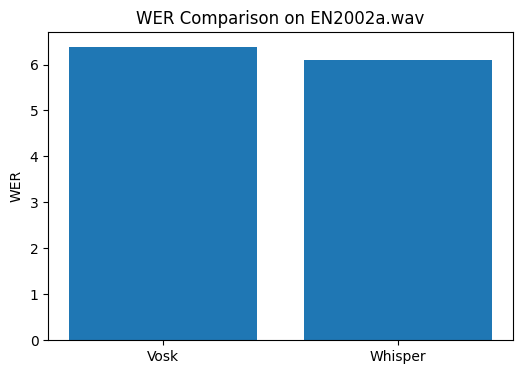

In [37]:
import matplotlib.pyplot as plt

labels = ["Vosk", "Whisper"]
wers = [vosk_wer, whisper_wer]

plt.figure(figsize=(6,4))
plt.bar(labels, wers)
plt.ylabel("WER")
plt.title("WER Comparison on EN2002a.wav")
plt.show()
